# PIC-SURE API for PrecisionLink Biobank

The PrecisionLink Biobank is a Boston Children’s Hospital institutional resource that
provides a centralized source of prospectively consented participants. To date, the
Biobank has enrolled over 15,000 patients and families, who have contributed health
data and biological samples for broad research use. Investigators are able to search the
holdings of the Biobank using the [PrecisionLink Biobank Portal](http://biobank.childrens.harvard.edu/).

The PrecisionLink Biobank Portal grants investigators access to genotype,
biospecimen, and clinical data - including clinical notes - from one search tool.
Furthermore, investigators are able to conduct multi-stage queries with any combination
of data criteria.

The Biobank is constantly growing through prospective enrollment of a broadly
consented cohort of patients and families, who can be re-contacted for additional
research opportunities.

## PIC-SURE python API
### What is PIC-SURE?

The Patient Information Commons Standard Unification of Research Elements (PIC-SURE) platform integrates clinical and genomic data from the PrecisionLink Biobank.

Original data exposed through the PIC-SURE API encompasses a large heterogeneity of data organization underneath. PIC-SURE hides this complexity and exposes the different study datasets in a single tabular format. By simplifying the process of data extraction, it allows investigators to focus on downstream analysis and to facilitate reproducible science.

More about PIC-SURE
The API is available in two different programming languages, python and R, enabling investigators to query the databases the same way using either language.

PIC-SURE is a larger project from which the R/python PIC-SURE API is only a brick. Among other things, PIC-SURE also offers a graphical user interface that allows researchers to explore variables across multiple studies, filter patients that match criteria, and create cohorts from this interactive exploration.

The python API is actively developed by the Avillach Lab at Harvard Medical School.

PIC-SURE API GitHub repo:

https://github.com/hms-dbmi/Access-to-Data-using-PIC-SURE-API/tree/master


 -------   

# Getting your own user-specific security token

**Before running this notebook, please be sure to review the "Get your security token" documentation, which exists in the BCH_Precision_Link [README.md file](https://github.com/hms-dbmi/Access-to-Data-using-PIC-SURE-API/tree/master). It explains about how to get a security token, which is mandatory to access the databases.**

# Environment set-up

### Pre-requisites
- python 3.6 or later
- pip python package manager, already available in most systems with a python interpreter installed ([pip installation instructions](https://pip.pypa.io/en/stable/installing/))

### Install Packages

Install the following:
- packages listed in the `requirements.txt` file (listed below, along with version numbers)
- PIC-SURE API components (from Github)
    - PIC-SURE Adapter 
    - PIC-SURE Client

In [1]:
!cat requirements.txt

numpy>=1.16.4
matplotlib>=3.1.1
pandas>=0.25.3
scipy>=1.3.1
tqdm>=4.38.0
statsmodels>=0.10.2


In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [3]:
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git
!{sys.executable} -m pip install --upgrade --force-reinstall git+https://github.com/hms-dbmi/pic-sure-python-client.git

  Cloning https://github.com/hms-dbmi/pic-sure-python-adapter-hpds.git to /private/var/folders/md/n67s7ghd64nb9_qdkx6l_7zw0000gn/T/pip-req-build-3oeoqamv
  Using cached https://files.pythonhosted.org/packages/15/dc/d14bce03f4bfd0214b90a3f556d7c96f75bb94ad597c816a641b962f22e9/httplib2-0.19.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Stored in directory: /private/var/folders/md/n67s7ghd64nb9_qdkx6l_7zw0000gn/T/pip-ephem-wheel-cache-z6hw6ga0/wheels/6c/ac/12/4d142709d83e0bdd96c661e183f2dcbb0e03f90e98e5ac256e
Successfully built PicSureHpdsLib
  Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
  Found existing installation: httplib2 0.19.1
    Uninstalling httplib2-0.19.1:
      Successfully uninstalled httplib2-0.19.1
  Found existing installation: PicSureHpdsLib 0.9.0
    Uninstal

Import all the external dependencies

In [4]:
import json
from pprint import pprint

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import PicSureHpdsLib
import PicSureClient

from python_lib.utils import get_multiIndex_variablesDict, joining_variablesDict_onCol

Set the display parameter for tables and plots

In [5]:
# Pandas DataFrame display options
pd.set_option("max.rows", 100)

# Matplotlib display parameters
plt.rcParams["figure.figsize"] = (14,8)
font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)

## Connecting to a PIC-SURE resource

The following is required to get access to data through the PIC-SURE API: 
- Network URL
- Resource ID
- User-specific security token

If you have not already retrieved your user-specific token, please refer to the "Get your security token" section of the [README.md](https://github.com/hms-dbmi/Access-to-Data-using-PIC-SURE-API/tree/master/NHLBI_BioData_Catalyst#get-your-security-token) file.

***Note: You will not be able to connect to the PrecisionLink PIC-SURE resource if you are not on the Boston Children's Hospital network. Please ensure that you are connected to the BCH network via one of these options:***
- ***TCH or BCH-R wireless options***
- ***the web or full Virtual Private Network (VPN)***

In [6]:
PICSURE_network_URL = "https://pl-portal.childrens.harvard.edu/picsure/"
resource_id = "6aa47730-3288-4c45-bfa1-5a8730666016"
token_file = "token.txt"

In [7]:
with open(token_file, "r") as f:
    my_token = f.read()

In [8]:
client = PicSureClient.Client()
connection = client.connect(PICSURE_network_URL, my_token, True)
adapter = PicSureHpdsLib.Adapter(connection)
resource = adapter.useResource(resource_id)



+=========================================================================================+
|        [ WARNING ] you are specifying that you WANT to allow self-signed SSL            |
|        certificates to be acceptable for connections.  This may be useful for           |
|        working in a development environment or on systems that host public              |
|        data.  BEST SECURITY PRACTICES ARE THAT IF YOU ARE WORKING WITH SENSITIVE        |
|        DATA THEN ALL SSL CERTS BY THOSE EVIRONMENTS SHOULD NOT BE SELF-SIGNED.          |
+=========================================================================================+

+--------------------------------------+------------------------------------------------------+
|  Resource UUID                       |  Resource Name                                       |
+--------------------------------------+------------------------------------------------------+
| 6aa47730-3288-4c45-bfa1-5a8730666016 | hpds                    

Two objects are created here: a `connection` and a `resource` object.

Since will only be using a single resource, **the `resource` object is actually the only one we will need to proceed with data analysis hereafter**. 

It is connected to the specific data source ID we specified and enables us to query and retrieve data from this database.

## Getting help with the PIC-SURE API

Each object exposed by the PicSureHpds library has a `help()` method. Calling it without parameters will print out  information about functionalities of this object.

In [9]:
resource.help()


        [HELP] PicSureHpdsLib.useResource(resource_uuid)
            .dictionary()       Used to access data dictionary of the resource
            .query()            Used to query against data in the resource
            .retrieveQueryResults(query_uuid) returns the results of an asynchronous query that has already been submitted to PICSURE

        [ENVIRONMENT]
              Endpoint URL: https://pl-portal.childrens.harvard.edu/picsure/
             Resource UUID: 6aa47730-3288-4c45-bfa1-5a8730666016


For instance, this output tells us that this `resource` object has 3 methods, and it gives a quick definition of those methods. 

## Using the *variables dictionary*

Once a connection to the desired resource has been established, we first need to understand which variables are available in the database. To this end, we will use the `dictionary` method of the `resource` object.

A `dictionary` instance enables us to retrieve matching records by searching for a specific term, or to retrieve information about all the available variables, using the `find()` method. For instance, looking for variables containing the term `Calcium` in their names is done this way: 

In [10]:
dictionary = resource.dictionary()
dictionary_search = dictionary.find("Calcium")

Note: Using the `dictionary.find()` function without arguments will return every entry, as shown in the help documentation.
We included the term "Calcium" as we are only interested in entries related to calcium.

Subsequently, objects created by the `dictionary.find` method expose the search results via 4 different methods: `.count()`, `.keys()`, `.entries()`, and `.DataFrame()`.

In [11]:
pprint({"Count": dictionary_search.count(), 
        "Keys": dictionary_search.keys()[0:5],
        "Entries": dictionary_search.entries()[0:5]})

{'Count': 90,
 'Entries': [{'HpdsDataType': 'phenotypes',
              'categorical': True,
              'categoryValues': ['Admitting',
                                 'Billing Diagnosis',
                                 'Discharge',
                                 'Final',
                                 'Final - Epic',
                                 'QCC',
                                 'Working'],
              'name': '\\Diagnosis\\ICD-10-CM Diagnoses (2015) with '
                      'ICD9\\Certain conditions originating in the perinatal '
                      'period (P00-P96)\\Transitory endocrine and metabolic '
                      'disorders specific to newborn (P70-P74)\\Transitory '
                      'neonatal disorders of calcium and magnesium '
                      'metabolism\\Neonatal hypomagnesemia\\Hypocalcemia and '
                      'hypomagnesemia of newborn\\',
              'observationCount': 697,
              'patientCount': 546},
     

**The `.DataFrame()` method enables us to get the result of the dictionary search in a pandas DataFrame format. This way, it allows us to:** 


* Use the various information exposed in the dictionary (patient count, variable type ...) as criteria for variable selection.
* Use the row names of the DataFrame to get the actual variable names to be used in the query, as shown below.

Variable names aren't very pratical to use right away for two reasons:
1. Very long
2. Presence of backslashes that prevent from copy-pasting. 

However, retrieving the dictionary search result in the form of a dataframe can help access the variable names.

In [12]:
dictionary_search.DataFrame().head()

,categorical,categoryValues,patientCount,observationCount,HpdsDataType,min,max
KEY,,,,,,,
\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Certain conditions originating in the perinatal period (P00-P96)\Transitory endocrine and metabolic disorders specific to newborn (P70-P74)\Transitory neonatal disorders of calcium and magnesium metabolism\Neonatal hypomagnesemia\Hypocalcemia and hypomagnesemia of newborn\,True,"[Admitting, Billing Diagnosis, Discharge, Fina...",546,697,phenotypes,NaN,NaN
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Certain conditions originating in the perinatal period (P00-P96)\Transitory endocrine and metabolic disorders specific to newborn (P70-P74)\Transitory neonatal disorders of calcium and magnesium metabolism\Transitory neonatal disorder of calcium and magnesium metabolism, unspecified\",True,"[Billing Diagnosis, Final, QCC]",7,30,phenotypes,NaN,NaN
\Medications\Any calcium lactate\,True,[H],20,20,phenotypes,NaN,NaN
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Injury, poisoning and certain other consequences of external causes (S00-T88)\Poisoning by, adverse effects of and underdosing of drugs, medicaments and biological substances (T36-T50)\Poisoning by, adverse effect of and underdosing of agents primarily affecting the cardiovascular system\Poisoning by, adverse effect of and underdosing of calcium-channel blockers\Poisoning by, adverse effect of and underdosing of calcium-channel blockers\Poisoning by calcium-channel blockers, accidental (unintentional)\Poisoning by calcium-channel blockers, accidental (unintentional), initial encounter\",True,"[Admitting, Billing Diagnosis, Discharge, Final]",55,144,phenotypes,NaN,NaN
\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Certain conditions originating in the perinatal period (P00-P96)\Transitory endocrine and metabolic disorders specific to newborn (P70-P74)\Transitory neonatal disorders of calcium and magnesium metabolism\Neonatal tetany without calcium or magnesium deficiency\,True,"[Billing Diagnosis, Final, QCC]",2,3,phenotypes,NaN,NaN


The dictionary currently returned by the API provides information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if strings, False if numerical
- min/max: only provided for numerical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently, the API only expsoses'phenotypes' variables

## Variable dictionary and pandas multiIndex

We can use a simple user-defined function (`get_multiIndex_variablesDict`) to add a little more information to the variable dictionary and to simplify working with variables names. It takes advantage of pandas MultiIndex functionality [see pandas official documentation on this topic](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html).

Although not an official feature of the API, such functionality illustrates how to quickly select groups of related variables.

Printing the multiIndexed variable Dictionary allows to quickly see the tree-like organization of the variable names. Moreover, original and simplified variable names are now stored respectively in the `varName` and `simplified_varName` columns (simplified variable names is simply the last component of the variable name, which is usually the most informative to know what each variable is about).

In [13]:
multiindex = get_multiIndex_variablesDict(dictionary_search.DataFrame())
multiindex.head().droplevel(['level_7', 'level_8', 'level_9'])

simplified_name  \
level_0   level_1                              level_2                                            level_3                                            level_4                                            level_5                                            level_6                                                                                         
Diagnosis ICD-10-CM Diagnoses (2015) with ICD9 Certain conditions originating in the perinatal... Transitory endocrine and metabolic disorders sp... Transitory neonatal disorders of calcium and ma... Cow's milk hypocalcemia in newborn                 NaN                                                        Cow's milk hypocalcemia in newborn   
                                                                                                                                                                                                                                                           Hypocalcemia and hypomagnesemia of newborn         Hypocalcemia and hypomagnesemia of newborn   
                                                                                                                                                                                                        Neonatal hypomagnesemia                            NaN                                                                   Neonatal hypomagnesemia   
                                                                                                                                                                                                                                                           Hypocalcemia and hypomagnesemia of newborn         Hypocalcemia and hypomagnesemia of newborn   
                                                                                                                                                                                                        Neonatal tetany without calcium or magnesium de... NaN                                         Neonatal tetany without calcium or magnesium d...   

                                                                                                                                                                                                                                                                                                                                                    name  \
level_0   level_1                              level_2                                            level_3                                            level_4                                            level_5                                            level_6                                                                                         
Diagnosis ICD-10-CM Diagnoses (2015) with ICD9 Certain conditions originating in the perinatal... Transitory endocrine and metabolic disorders sp... Transitory neonatal disorders of calcium and ma... Cow's milk hypocalcemia in newborn                 NaN                                         \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                                                                                                                           Hypocalcemia and hypomagnesemia of newborn  \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                                                                        Neonatal hypomagnesemia                            NaN                                         \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                        

Below is a simple example to illustrate the simplicity of using a multiIndex dictionary. Let's say we are interested in every variable in the "diseases of the respiratory system" category.

In [14]:
full_multiindex = get_multiIndex_variablesDict(dictionary.find().DataFrame()) # Get full dataframe of variables
# Find variables that have "diseases of the respiratory system" in level_2
mask_resp_diseases = [type(i) == str and "Diseases of the respiratory system" in i for i in full_multiindex.index.get_level_values(2)] 
# Filter to those variables
resp_diseases_vars = full_multiindex.loc[mask_resp_diseases, :]

In [15]:
# Cleaning up for preview of dataframe
preview = resp_diseases_vars.head()
preview.droplevel(['level_7', 'level_8', 'level_9'])

simplified_name  \
level_0   level_1                              level_2                                      level_3                                      level_4                         level_5                         level_6                                                                                            
Diagnosis ICD-10-CM Diagnoses (2015) with ICD9 Diseases of the respiratory system (J00-J99) Acute upper respiratory infections (J00-J06) Acute laryngitis and tracheitis Acute laryngitis and tracheitis NaN                                                              Acute laryngitis and tracheitis   
                                                                                                                                                                         Acute laryngitis                NaN                                                                             Acute laryngitis   
                                                                                                                                                                                                         Acute laryngitis without mention of obstruction  Acute laryngitis without mention of obstruction   
                                                                                                                                                                                                         Acute laryngitis                                                                Acute laryngitis   
                                                                                                                                                                         Acute laryngotracheitis         NaN                                                                      Acute laryngotracheitis   

                                                                                                                                                                                                                                                                                                       name  \
level_0   level_1                              level_2                                      level_3                                      level_4                         level_5                         level_6                                                                                              
Diagnosis ICD-10-CM Diagnoses (2015) with ICD9 Diseases of the respiratory system (J00-J99) Acute upper respiratory infections (J00-J06) Acute laryngitis and tracheitis Acute laryngitis and tracheitis NaN                                              \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                                         Acute laryngitis                NaN                                              \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                                                                         Acute laryngitis without mention of obstruction  \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                                                                         Acute laryngitis                                 \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   
                                                                                                                                                                         Acute laryngotracheitis         NaN                                              \Diagnosis\ICD-10-CM Diagnoses (2015) with ICD...   

                                                    

Although pretty simple, it can be easily combined with other filters to quickly select one or more desired groups of variables.

## Querying and retrieving data: Epilepsy and *GRIN2A*

The second cornerstone of the API is the `query` object. It is how we retrieve data from the resource.

First, we need to create a query object.

In [16]:
my_query = resource.query()

The query object has several methods that enable to build a query.

| Method | Arguments / Input | Output|
|--------|-------------------|-------|
| query.select.add() | variable names (string) or list of strings | all variables included in the list (no record subsetting)|
| query.require.add() | variable names (string) or list of strings | all variables; only records that do not contain null values for input variables |
| query.anyof.add() | variable names (string) or list of strings | all variables; only records that contain at least one non-null value for input variables |
| query.filter.add() | variable name and additional filtering values | input variable; only records that match filter criteria |

All 4 methods can be combined when building a query. The record eventually returned by the query have to meet all the different specified filters.

### Building the query
In the following example, we are going to build a query to return data the counts of patients who:
- had epilepsy and recurrent seizures
- had a novel *GRIN2A* gene variant of high or moderate severity

#### Add phenotypic variable: Epilepsy

First, let's review the possible variable names with the term "epilepsy".

In [17]:
epilepsy_search = dictionary.find("epilepsy").DataFrame()
epilepsy_search

,categorical,categoryValues,patientCount,observationCount,HpdsDataType
KEY,,,,,
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Partial epilepsy, with impairment of consciousness\",True,"[Admitting, Final]",653,1237,phenotypes
\Laboratory Results\Laboratory\Genetics Metabolism\Childhood Epilepsy Sequencing Panel\,True,"[DUPLICATE, See Image]",14,15,phenotypes
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Epileptic seizures related to external causes\Epileptic seizures related to external causes, not intractable\Epileptic seizures related to external causes, not intractable, without status epilepticus\Other forms of epilepsy, without mention of intractable epilepsy\",True,"[Admitting, Billing Diagnosis, Discharge, Fina...",2337,9509,phenotypes
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Epilepsy, unspecified\Epilepsy, unspecified, not intractable\Epilepsy, unspecified, not intractable, with status epilepticus\Epilepsy, unspecified, without mention of intractable epilepsy\",True,"[Admitting, Billing Diagnosis, Discharge, Fina...",18142,85151,phenotypes
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures\Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures, not intractable\Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures, not intractable, without status epilepticus\",True,"[Admitting, Billing Diagnosis, Discharge, Fina...",3014,25638,phenotypes
...,...,...,...,...,...
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures\Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures, not intractable\Localization-related (focal) (partial) symptomatic epilepsy and epileptic syndromes with complex partial seizures, not intractable, without status epilepticus\Partial epilepsy, with impairment of consciousness, without mention of intractable epilepsy\",True,"[Admitting, Billing Diagnosis, Discharge, Fina...",11306,51611,phenotypes
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Other generalized epilepsy and epileptic syndromes\Other generalized epilepsy and epileptic syndromes, not intractable\Other generalized epilepsy and epileptic syndromes, not intractable, without status epilepticus\",True,"[Admitting, Billing Diagnosis, Discharge, Fina...",3036,22457,phenotypes
"\Diagnosis\ICD-10-CM Diagnoses (2015) with ICD9\Diseases of the nervous system (G00-G99)\Episodic and paroxysmal disorders (G40-G47)\Epilepsy and recurrent seizures\Other epilepsy and recurrent seizures\Other epilepsy\Other epilepsy, not intractable, without status epilepticus\Other forms of epilepsy, without mention of intractable epilepsy\",True,"[Admitting, Billing Diagnosis, Discharge, Fina...",2337,9509,phenotypes


We are interested in all variables pertaining to "Epilepsy and recurrent seizures", which is listed as one of the levels in the concept paths shown in the "KEY" column. We will now filter to all variables that meet this criteria.

In [18]:
mask_epilepsy = ["Epilepsy and recurrent seizures" in i for i in epilepsy_search.index]
epilepsy_vars = list(epilepsy_search[mask_epilepsy].index)

Now we can add these variables to our query. We can also view the patient count using the `getCount()` method.

In [19]:
my_query.anyof().add(epilepsy_vars)
my_query.getCount()

44632

#### Add genomic variable: *GRIN2A*

Next, we will filter to the gene *GRIN2A*. We can do this by filtering the "Gene_with_variant" key to the "GRIN2A" value.

In [20]:
gene_search = dictionary.find("Gene_with_variant").keys()
gene_search

['Gene_with_variant']

In [21]:
my_query.filter().add(gene_search, "GRIN2A")
my_query.getCount()

928

#### Add genomic variable: Variant severity

We will filter to variants of high severity using the "Variant_severity" key with "High" and "Moderate" values.

In [22]:
severity_search = dictionary.find("Variant_severity").keys()
severity_search

['Variant_severity']

In [23]:
my_query.filter().add(severity_search, ["HIGH", "MODERATE"])
my_query.getCount()

45

#### Add genomic variable: Variant frequency

Finally, we will filter to novel variants. Let's take a look at the "Variant_frequency" variable options.

In [24]:
frequency_search = dictionary.find("Variant_frequency").DataFrame()
frequency_search

,description,HpdsDataType,categorical,categoryValues
KEY,,,,
Variant_frequency_as_text,"Description=""The variant allele frequency in g...",info,True,"[Novel, Rare, Common]"


"Variant_frequency_as_text" has category values of Novel, Rare, and Common. Since we are interested in novel variants, we will use this key moving forward.

In [25]:
my_query.filter().add("Variant_frequency_as_text", "Novel")
my_query.getCount()

9

### Retrieving query counts: Percentage of patients with gene variants and epilepsies

The genetic associations of different epilepsies are explored and listed in [this article](https://www.sciencedirect.com/science/article/pii/S1059131116302989). We can explore these results in the PrecisionLink Biobank to determine the percentage of patients with different epilepsies that possess variants in different genes.

First we will initialize a new query.

In [26]:
epi_query = resource.query()

Then we will select the epilepsies we are interested in. For this example, let's use five of the epilepsy variables that we identified in the prior example.

We can add these variables to the query using `crosscounts()` to retrieve the number of patients that meet our criteria for each variable. 

In [27]:
epilepsy_vars_subset = epilepsy_vars[5:10]
epi_query.crosscounts().add(epilepsy_vars_subset)

We can identify a list of genes that we are interested in. These genes were taken from the article linked above.

In [28]:
gene_list = ['GABRG2', 'GABRD', 'KCNQ2']

Now we can use code to find:
1. The total number of patients with genomic data with each type of epilepsy. This is accomplished using the `Gene_with_variant` filter.
2. The number of patients with high or moderate severity of each gene variant and each type of epilepsy. This is accomplished using the `Variant_severity` filter.

In [29]:
# Initialize empty lists for results
full_counts = []
results = []

# Go through each gene of interest 
for genes in gene_list:
    # Find total number of patients with genomic data using Variant_severity
    epi_query.filter().add("Variant_severity", ["HIGH", "MODERATE"]) # Add filter
    #epi_query.filter().add("Variant_frequency_as_text", "Novel")
    epi_query.filter().add("Gene_with_variant", genes) # Add filter
    counts = epi_query.getCrossCounts().values() # Get counts for each epilepsy variable
    for i in counts:
        full_counts.append(i)
    epi_query.filter().delete("Variant_severity") # Remove filter
    #epi_query.filter().delete("Variant_frequency_as_text")
    
    # Find total number of patients with gene variant using Gene_with_variant
    #epi_query.filter().add("Gene_with_variant", genes) # Add filter
    res = epi_query.getCrossCounts().values() # Get counts for each epilepsy variable
    for i in res:
        results.append(i)
    epi_query.filter().delete("Gene_with_variant") # Remove filter
    

Deleted key: Variant_severity
Deleted key: Gene_with_variant
Deleted key: Variant_severity
Deleted key: Gene_with_variant
Deleted key: Variant_severity
Deleted key: Gene_with_variant


Now that we have retrieved our counts, we can calculate the percentage of patients that have high or moderate gene variants and use our resulting dataframe to create a heatmap.

In [30]:
final = np.array(results).reshape(3, 5)
final = np.transpose(final)

full_final = np.array(full_counts).reshape(3, 5)
full_final = np.transpose(full_final)

full_results = final/full_final

In [31]:
# For labelling purposes
for_plotting = []
for var in epilepsy_vars_subset:
    for_plotting.append(var.split('\\')[-2])

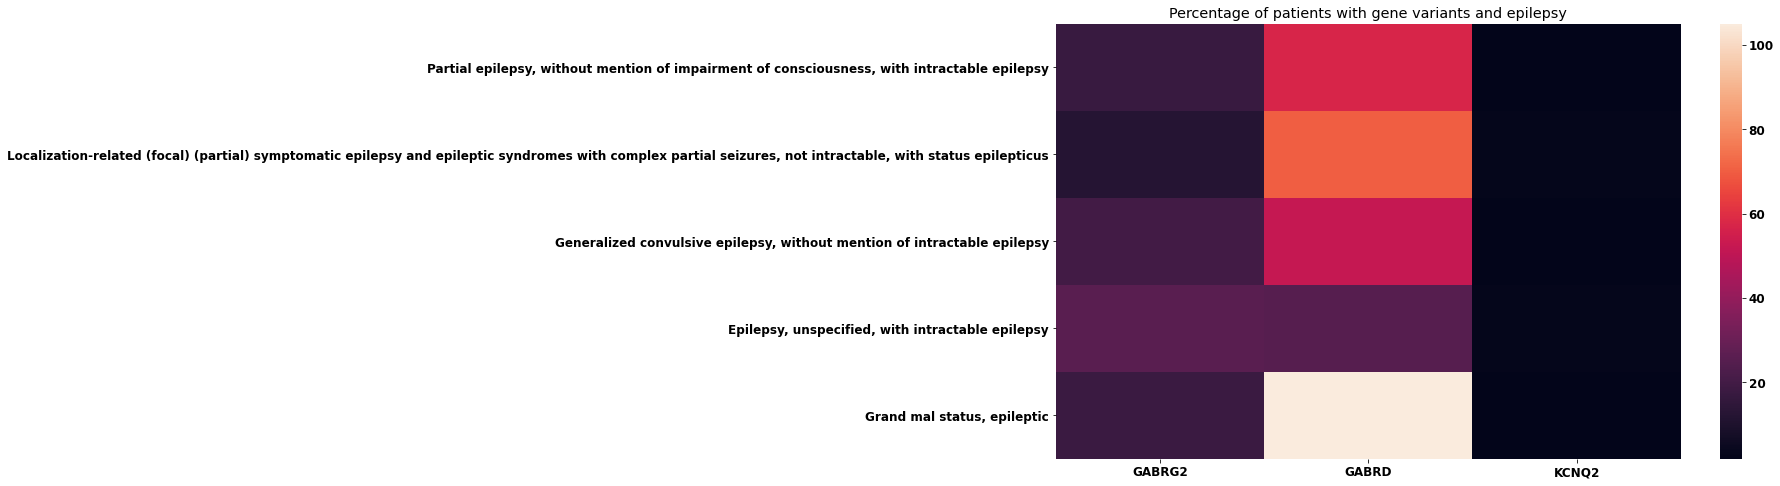

In [32]:
ax = sns.heatmap(full_results, yticklabels = for_plotting, xticklabels=gene_list)
ax.set_title("Percentage of patients with gene variants and epilepsy")
plt.show()